In [8]:
%matplotlib inline
from helperFunctions import *
from constants import *
from dataAnalysisFunctions import getSEM, getCleanedSignal, getIntervals, getPowerRatio
import pandas as pd

from featureBuilder import featureBuilder

import warnings
warnings.filterwarnings("ignore")

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#Import svm model
from sklearn import svm


## Build dataframes and variables needed

In [10]:
# Load datas and concat into one dataframe 
# Load dataset 1
foldername='P001'
filename='part_P001_block_S004'
#filtered_data = loadData(datatype='filtered_data', foldername=foldername, filename=filename)
#filtered_cleaned_data = loadData(datatype='filtered_cleaned_data', foldername=foldername, filename=filename)
df1 = loadData(datatype='dataframe', foldername=foldername, filename=filename)

# Load dataset 2
foldername='P001'
filename='part_P001_block_S005'
df2 = loadData(datatype='dataframe', foldername=foldername, filename=filename)

df = pd.concat([df1, df2], ignore_index=True)

In [11]:
# Select the trials needed to classify
focused_state = df["trial_time"] == 0.7
unfocused_state = df["trial_time"] > 0.9
med_state = ((df["trial_time"] > 0.7) & (df["trial_time"] <= 0.9))

focused_df = df[focused_state]
unfocused_df = df[unfocused_state]
med_df = df[med_state]

num_to_keep = min(len(focused_df), len(unfocused_df), len(med_df))

focused_df = focused_df.drop(focused_df.sample(len(focused_df) - num_to_keep).index)
unfocused_df = unfocused_df.drop(unfocused_df.sample(len(unfocused_df) - num_to_keep).index)
med_df = med_df.drop(med_df.sample(len(med_df) - num_to_keep).index)

print("focused len:", len(focused_df), "unfocused len:", len(unfocused_df), "med len:", len(med_df))


focused len: 420 unfocused len: 420 med len: 420


In [23]:
# Create the dataframes
fb = featureBuilder()
dictionary = {}

for row_index,row in unfocused_df.iterrows():
    dictionary = fb.appendDataToDict(row["data_extended"], focused=0, dictionary=dictionary)
for row_index,row in med_df.iterrows():
    dictionary = fb.appendDataToDict(row["data_extended"], focused=1, dictionary=dictionary)
for row_index,row in focused_df.iterrows():
    dictionary = fb.appendDataToDict(row["data_extended"], focused=2, dictionary=dictionary)

feature_df = pd.DataFrame(dictionary)
len(feature_df)

1260

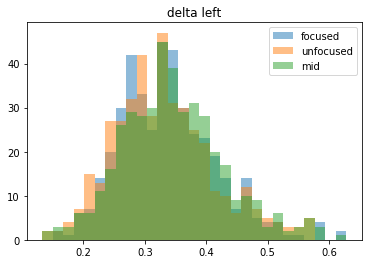

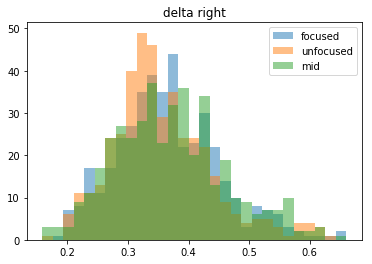

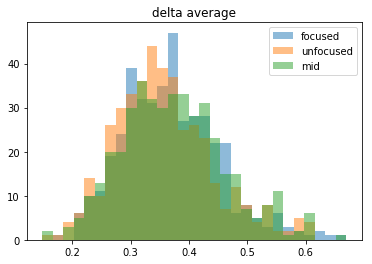

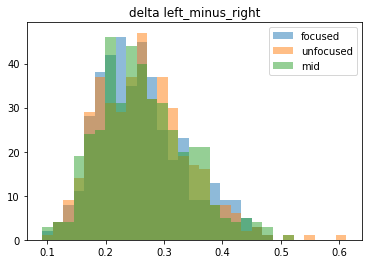

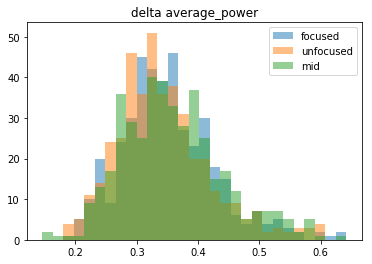

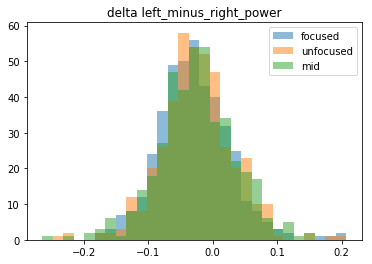

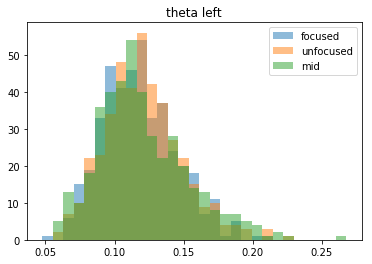

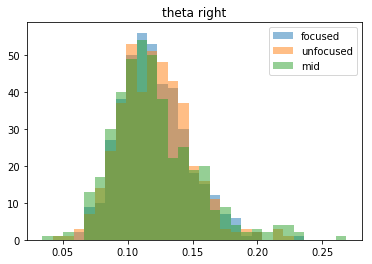

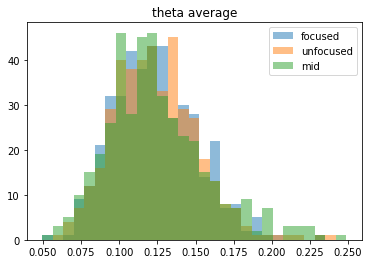

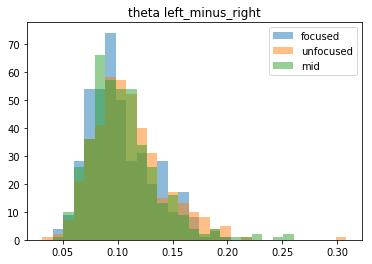

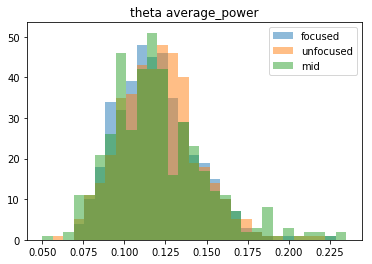

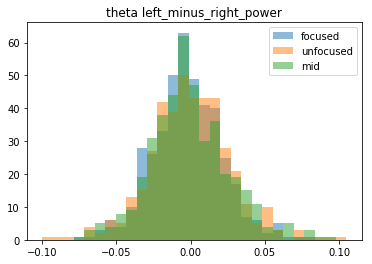

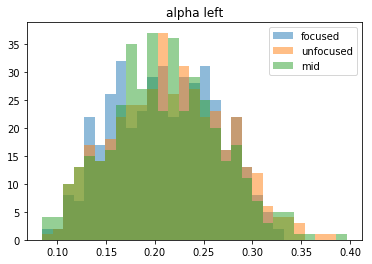

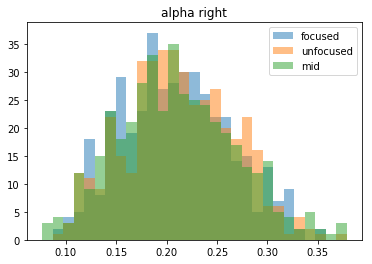

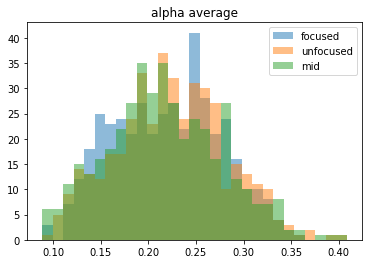

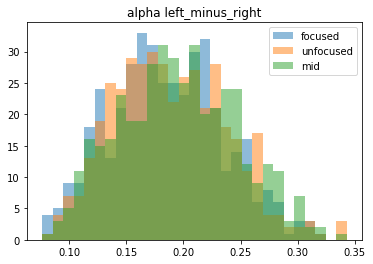

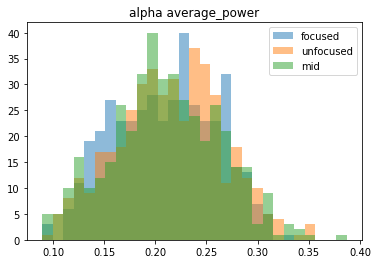

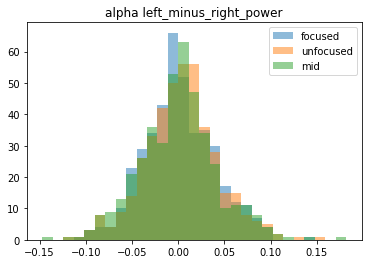

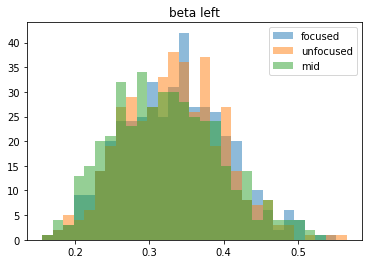

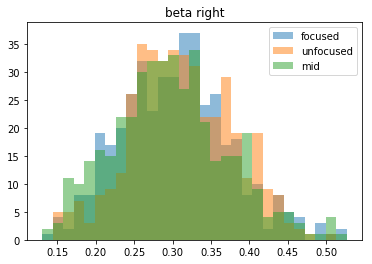

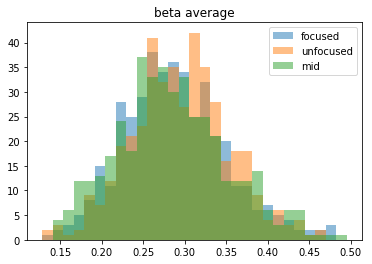

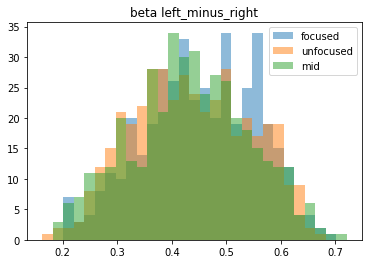

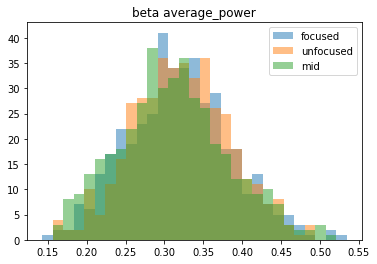

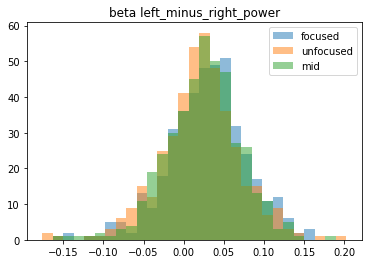

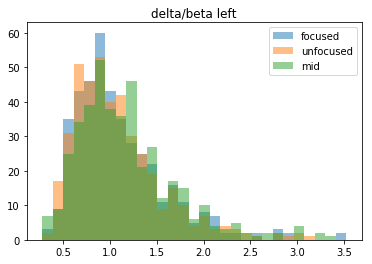

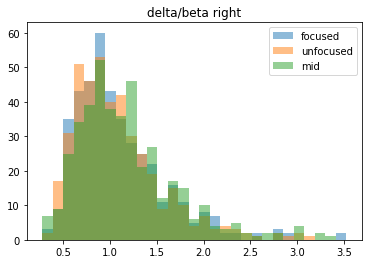

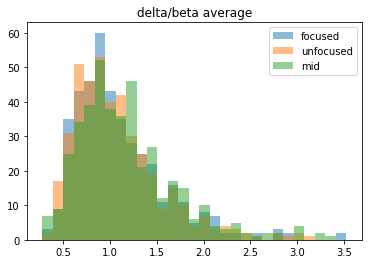

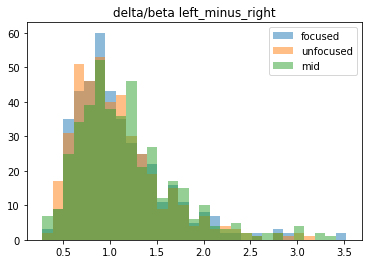

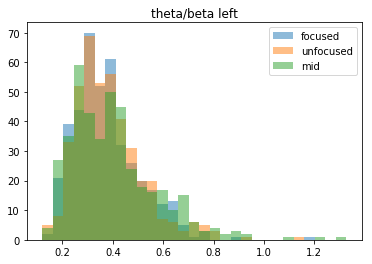

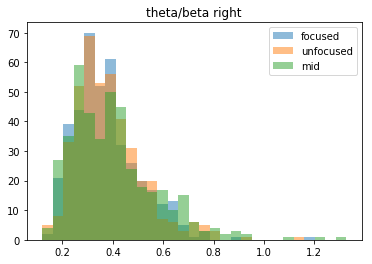

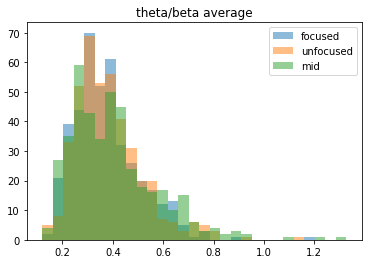

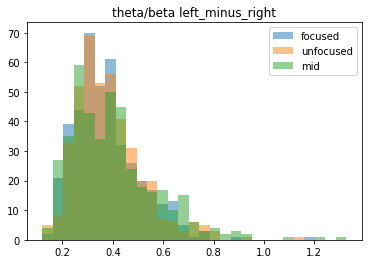

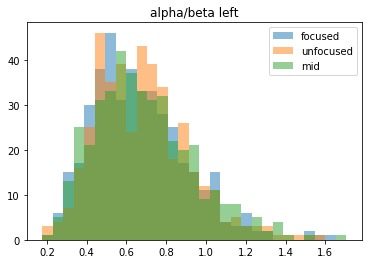

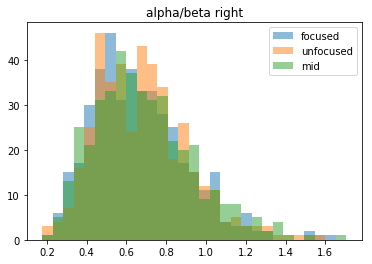

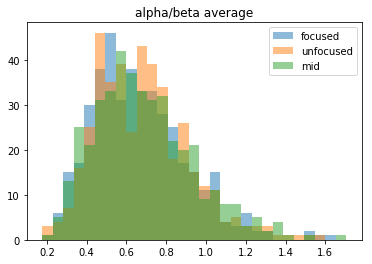

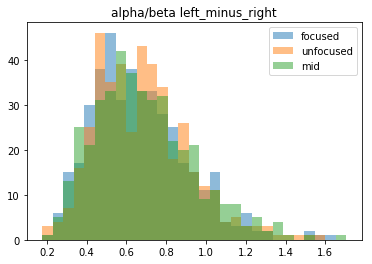

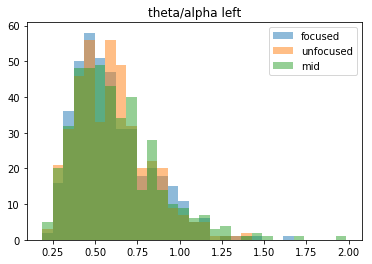

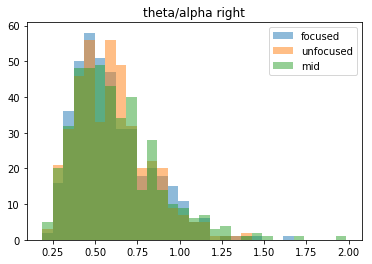

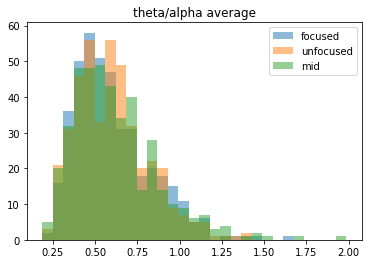

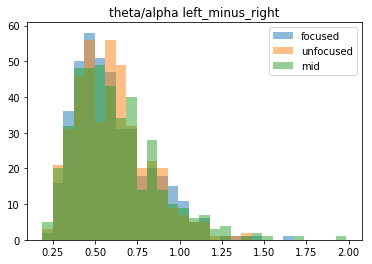

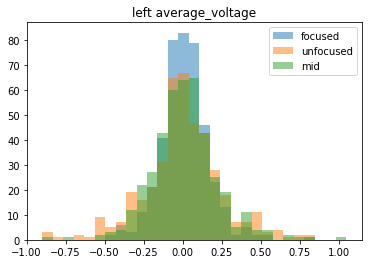

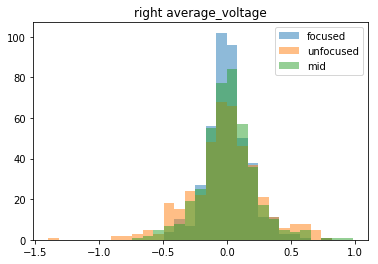

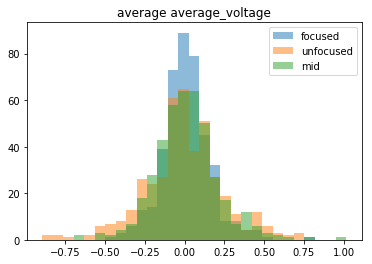

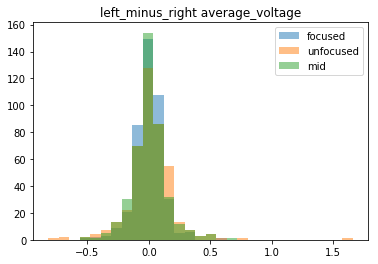

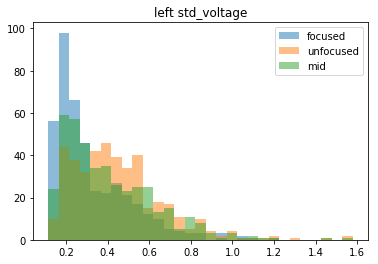

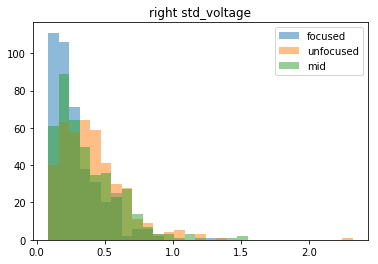

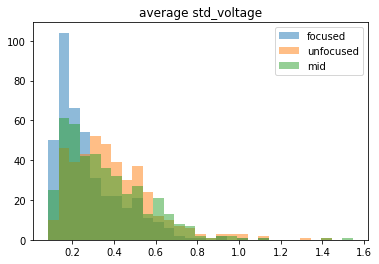

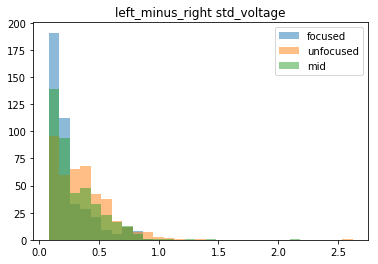

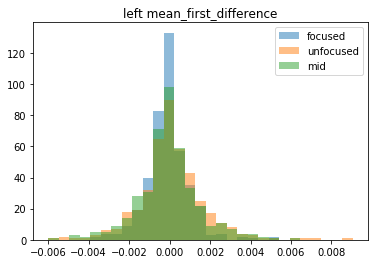

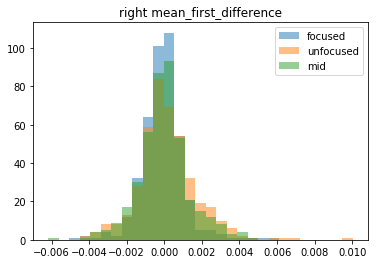

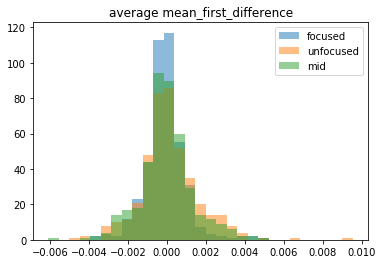

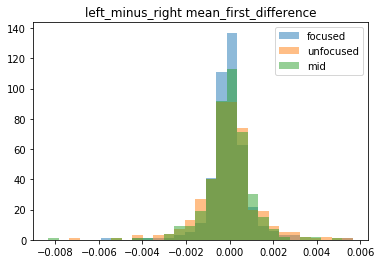

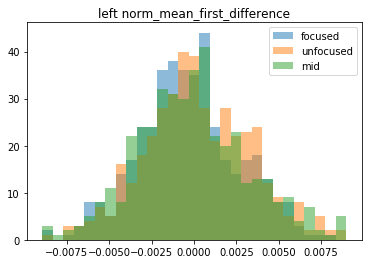

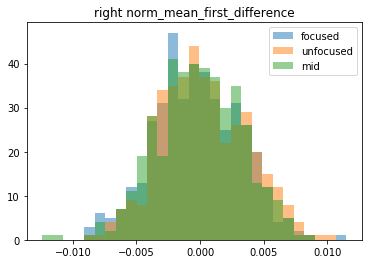

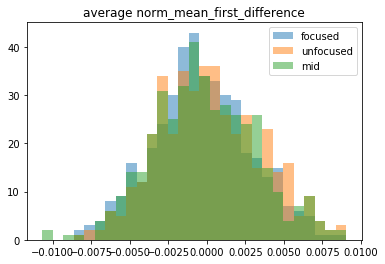

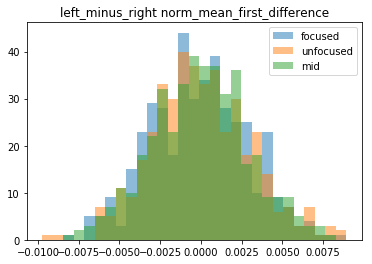

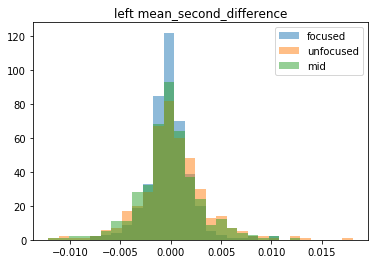

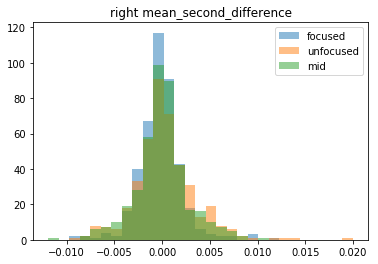

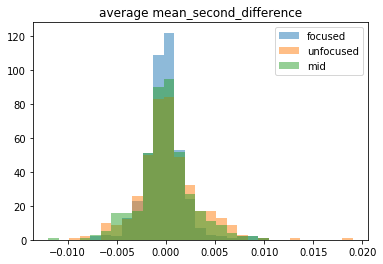

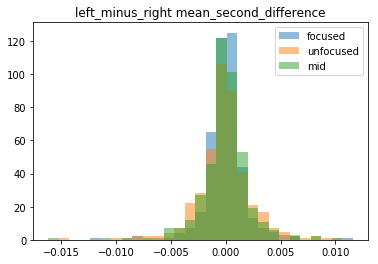

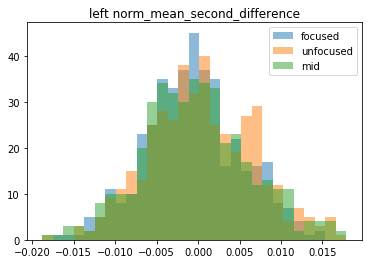

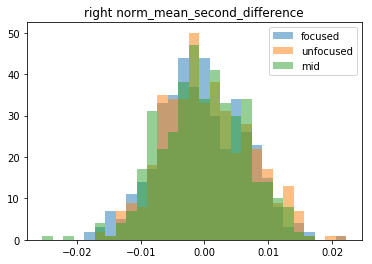

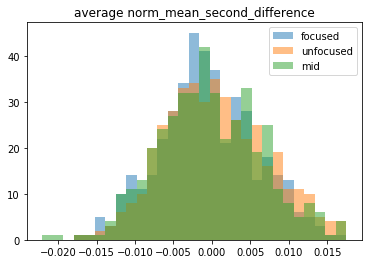

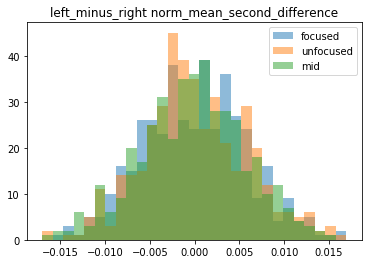

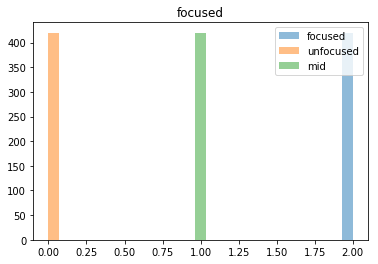

In [26]:
for col in feature_df.columns: 
    full_data = feature_df[col].values
    bins = np.linspace(min(full_data), max(full_data), 30)
    
    data = feature_df[feature_df['focused'] == 2][col].values
    plt.hist(data, bins=bins, alpha=0.5, label="focused") 
    
    data = feature_df[feature_df['focused'] == 0][col].values
    plt.hist(data, bins=bins, alpha=0.5, label="unfocused") 
    
    data = feature_df[feature_df['focused'] == 1][col].values
    plt.hist(data, bins=bins, alpha=0.5, label="mid") 
    
    
    
    plt.title(col)
    plt.legend()
    plt.show()

## LDA using sklearn 2D (3 possible outputs)
https://stackabuse.com/implementing-lda-in-python-with-scikit-learn/

In [14]:
# Average the accuracy over X different random samples
accuracies = []
for rand_state_var in range(10): 
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(feature_df.drop(columns=["focused"]), feature_df["focused"], test_size=0.2, random_state=rand_state_var)

    lda = LinearDiscriminantAnalysis(n_components=2)
    features_wo_output = feature_df.drop(columns=["focused"])
    X_train, scaler = scaleData(X_train, X_train.columns.values) # Scaling doesn't change anything
    X_test = scaler.transform(X_test)
    X_train = lda.fit_transform(X_train, y_train)
    X_test = lda.transform(X_test)


    ## Classify using random forest classifier
    classifier = RandomForestClassifier(max_depth=2, random_state=0)

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    # Report accuracy
    # cm = confusion_matrix(y_test, y_pred)
    # print(cm)
    print('Accuracy', str(accuracy_score(y_test, y_pred)))
    accuracies.append(accuracy_score(y_test, y_pred))
print("Avg accuracy:", np.mean(np.array(accuracies)))

Accuracy 0.4246031746031746
Accuracy 0.4365079365079365
Accuracy 0.4126984126984127
Accuracy 0.4246031746031746
Accuracy 0.45634920634920634
Accuracy 0.44047619047619047
Accuracy 0.4166666666666667
Accuracy 0.4722222222222222
Accuracy 0.4523809523809524
Accuracy 0.4365079365079365
Avg accuracy: 0.43730158730158736


In [15]:
# Average the accuracy over X different random samples
accuracies = []
for rand_state_var in range(10): 
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(feature_df.drop(columns=["focused"]), feature_df["focused"], test_size=0.2, random_state=rand_state_var)

    lda = LinearDiscriminantAnalysis(n_components=2)
    features_wo_output = feature_df.drop(columns=["focused"])
    X_train, scaler = scaleData(X_train, X_train.columns.values) # Scaling doesn't change anything
    X_test = scaler.transform(X_test)
    X_train = lda.fit_transform(X_train, y_train)
    X_test = lda.transform(X_test)


    ## Classify using SVM
    #Create a svm Classifier
    clf = svm.SVC(kernel='linear') # Linear Kernel

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    # Report accuracy
    #cm = confusion_matrix(y_test, y_pred)
    #print(cm)
    print('Accuracy', str(accuracy_score(y_test, y_pred)))
    accuracies.append(accuracy_score(y_test, y_pred))
print("Avg LDA + SMV accuracy:", np.mean(np.array(accuracies)))

Accuracy 0.42063492063492064
Accuracy 0.4642857142857143
Accuracy 0.42857142857142855
Accuracy 0.4166666666666667
Accuracy 0.48412698412698413
Accuracy 0.44047619047619047
Accuracy 0.4880952380952381
Accuracy 0.44047619047619047
Accuracy 0.45634920634920634
Accuracy 0.4523809523809524
Avg LDA + SMV accuracy: 0.4492063492063492


In [17]:
zipped_list = list(zip(lda.coef_[0], feature_df.drop(columns="focused").columns))
sorted_zip_list = sorted(zipped_list)
sorted_zip_list

[(-46.972282053549456, 'average norm_mean_second_difference'),
 (-31.254259554151325, 'right norm_mean_first_difference'),
 (-20.02977381443869, 'left norm_mean_first_difference'),
 (-5.235236934210336, 'left_minus_right norm_mean_first_difference'),
 (-3.1469836535545563, 'left_minus_right mean_second_difference'),
 (-1.688740379916843, 'beta left'),
 (-1.4105559379438888, 'beta average_power'),
 (-1.3789459383608607, 'beta left_minus_right_power'),
 (-1.226679292342375, 'theta average'),
 (-1.2231448045794342, 'right mean_first_difference'),
 (-1.050781841840171, 'alpha left_minus_right'),
 (-1.0440559626784518, 'theta/beta left_minus_right'),
 (-1.0440559626784085, 'theta/beta average'),
 (-1.04405596267839, 'theta/beta right'),
 (-1.0440559626783472, 'theta/beta left'),
 (-0.9625010692973097, 'delta left_minus_right'),
 (-0.8941949155843877, 'beta right'),
 (-0.8911657455363028, 'left mean_second_difference'),
 (-0.7994231370296434, 'alpha/beta average'),
 (-0.7994231370296303, 'al

LDA explained variance: [0.7046201 0.2953799]


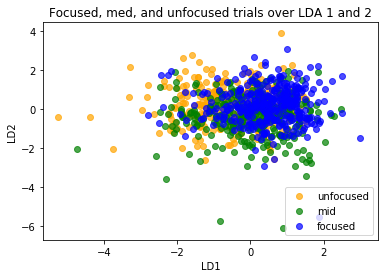

In [25]:
# Visualize LDA model 
class_names={2:"focused", 1:"mid", 0:"unfocused"}
colors={2:"blue", 1:"green", 0:"orange"}

print("LDA explained variance:", lda.explained_variance_ratio_)

# Create dataframe for the feature
lda_feature_df = pd.DataFrame(X_train, columns=['LDA 1', 'LDA 2'])
lda_feature_df['focused']=y_train.values

# Plot groups wrt LDA 1 dimension
plt.xlabel('LD1')
plt.ylabel('LD2')

for class_name, df in lda_feature_df.groupby('focused'): 
    plt.scatter(
        df['LDA 1'].values,
        df['LDA 2'].values,
        c=colors[class_name],
        cmap='rainbow',
        alpha=0.7,
        label=class_names[class_name]
    )
plt.legend(loc='lower right')
plt.title("Focused, med, and unfocused trials over LDA 1 and 2")
plt.show()

## LDA manual
https://towardsdatascience.com/linear-discriminant-analysis-in-python-76b8b17817c2

In [9]:
class_feature_means = pd.DataFrame(columns=[False,True])
for class_name, rows in feature_df.groupby('focused'):
    class_feature_means[class_name] = rows.mean()
    
class_feature_means = class_feature_means.drop(['focused'])

In [10]:
num_features = len(class_feature_means)
within_class_scatter_matrix = np.zeros((num_features, num_features))
for c,rows in feature_df.groupby('focused'):
    rows=rows.drop(columns=['focused'])
    s = np.zeros((num_features, num_features))
    for index, row in rows.iterrows():
        x, mc = row.values.reshape(num_features, 1), class_feature_means[c].values.reshape(num_features, 1)
        s += (x-mc).dot((x-mc).T)
    within_class_scatter_matrix += s


In [11]:
feature_means = feature_df.mean().drop(['focused'])
between_class_scatter_matrix = np.zeros((num_features, num_features))
for c,rows in feature_df.groupby('focused'):
    rows=rows.drop(columns=['focused'])
    n = len(rows)
    mc, m = class_feature_means[c].values.reshape(num_features, 1), feature_means.values.reshape(num_features, 1)
    between_class_scatter_matrix += n*(mc - m).dot((mc - m).T)

In [12]:
within_class_scatter_matrix.shape

(48, 48)

In [13]:
between_class_scatter_matrix.shape

(48, 48)

In [14]:
inv_within_class_scatter_matrix = np.linalg.pinv(within_class_scatter_matrix)

In [15]:
eigen_values, eigen_vectors = np.linalg.eig(inv_within_class_scatter_matrix.dot(between_class_scatter_matrix))


In [16]:
pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]
pairs = sorted(pairs, key=lambda x: x[0], reverse=True)
for pair in pairs:
    print(pair[0])

0.07439846588569235
0.04452282272393282
2.0868280427213818e-14
1.5123316424826227e-15
1.5123316424826227e-15
5.754735996385016e-16
3.439518326318062e-16
3.439518326318062e-16
3.385523825697202e-16
3.385523825697202e-16
2.236079651981054e-16
2.236079651981054e-16
1.33739450609809e-16
9.002336826778142e-17
7.935343273276738e-17
7.935343273276738e-17
6.85247219982934e-17
6.85247219982934e-17
3.205082604874352e-17
3.205082604874352e-17
2.8886081893529797e-17
2.8886081893529797e-17
2.6983657120515852e-17
2.2855072162304146e-17
2.2855072162304146e-17
2.2138539113267897e-17
1.6817496487767113e-17
1.6817496487767113e-17
1.1009146822585187e-17
7.536064545249375e-18
7.536064545249375e-18
7.48710141115237e-18
2.246404439402795e-18
2.246404439402795e-18
1.8641970983377276e-18
7.425390831785608e-19
7.623503733058104e-20
8.89978199465219e-21
3.1252883078545843e-33
3.1252883078545843e-33
1.3245076459038125e-33
1.3245076459038125e-33
7.161231434006543e-34
7.161231434006543e-34
7.15079112222706e-34
2.8

In [17]:
w_matrix = np.hstack((pairs[0][1].reshape(num_features,1), pairs[1][1].reshape(num_features,1))).real


In [18]:
eigen_value_sums = sum(eigen_values)
print('Explained Variance')
for i, pair in enumerate(pairs):
    print('Eigenvector {}: {}'.format(i, (pair[0]/eigen_value_sums).real))

Explained Variance
Eigenvector 0: 0.6256109966141358
Eigenvector 1: 0.37438900338603254
Eigenvector 2: 1.754797704532131e-13
Eigenvector 3: 1.2717080853767953e-14
Eigenvector 4: 1.2717080853767953e-14
Eigenvector 5: 4.8391133863985155e-15
Eigenvector 6: 2.8922645949534854e-15
Eigenvector 7: 2.8922645949534854e-15
Eigenvector 8: 2.846861033276557e-15
Eigenvector 9: 2.846861033276557e-15
Eigenvector 10: 1.880302238669526e-15
Eigenvector 11: 1.880302238669526e-15
Eigenvector 12: 1.12460478837266e-15
Eigenvector 13: 7.569996030173384e-16
Eigenvector 14: 6.672769330079231e-16
Eigenvector 15: 6.672769330079231e-16
Eigenvector 16: 5.762191345171712e-16
Eigenvector 17: 5.762191345171712e-16
Eigenvector 18: 2.6951293938598314e-16
Eigenvector 19: 2.6951293938598314e-16
Eigenvector 20: 2.429008483784349e-16
Eigenvector 21: 2.429008483784349e-16
Eigenvector 22: 2.269035042926402e-16
Eigenvector 23: 1.9218654985595376e-16
Eigenvector 24: 1.9218654985595376e-16
Eigenvector 25: 1.8616127837248972e-16

In [19]:
X_lda = np.array(feature_df.drop(columns=['focused']).dot(w_matrix))
X_lda

array([[-0.02958873,  0.11114413],
       [-0.03088476,  0.11393677],
       [-0.0199063 ,  0.12228797],
       ...,
       [-0.02839349,  0.11589241],
       [-0.02494543,  0.1146035 ],
       [-0.03061596,  0.1065048 ]])

In [20]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(feature_df['focused'])

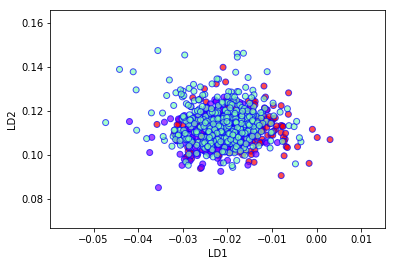

In [21]:
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(
    X_lda[:,0],
    X_lda[:,1],
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)